# imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import re
from hazm import Normalizer, word_tokenize

import torch
from torch.utils.data import DataLoader
from torch import nn, optim

import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig

# read csv and preprocessing texts

In [4]:
comments = pd.read_csv("dataset/Instagram_labeled_comments.csv").drop("Unnamed: 0", axis=1).reset_index(drop=True)

In [5]:
comments.shape

(8512, 2)

In [8]:
print(comments.isna().sum())

comment      0
sentiment    0
dtype: int64


In [9]:
comments = comments.drop_duplicates(subset=['comment'], keep='first')
comments.shape

(8502, 2)

In [10]:
e = ("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
     "]+")
allemojies = set()
def removeEmojies(text):
    duplemoj = re.compile('(' + e + '){2,}|((' + e + r')\s+)' '{2,}', re.UNICODE)
    return duplemoj.sub('', text)

* normalizing texts using hazm library
* replace all underline character with ZWNJ character
* remove meaningless english vocabs
* remove spammed punctuations and replace it with one of each character
* remove duplicate emojies (tried without emoji too)
* find all emojies to add them later to tokenizer
* remove extra spaces

In [5]:
punctuation = "?.؟!،,"
normalizer = Normalizer()
def preprocessing(item):
    output = normalizer.normalize(item)
    output = output.replace("\_", "\u200c")
#     output = output.replace("\u200c", "")
    output = re.sub(r"LINK([^ ])*|TAG|ID|\-|@|LINK|[A-Za-z]", "", output)
    for i in punctuation:
        p = "\\" + i + "{2,}"
        output = re.sub(p, i, output)
#     output = re.sub("\?|\.|\؟|\!|\،|\,", "", output)
    output = removeEmojies(output)
    emoj = re.compile(e)
    for i in emoj.findall(output):
        allemojies.add(i)
    output = re.sub("\s+", " ", output).strip()
    return output

comments['comment'] = comments['comment'].apply(preprocessing)
comments['len words'] = comments['comment'].apply(lambda x: len(word_tokenize(x)))
comments['len chars'] = comments['comment'].apply(lambda x: len(x))
comments = comments[comments['len chars'] >= 3].reset_index(drop=True)
maxlen = comments['len words'].max()
# crossentropy inputs should be in range [0, C-1] so
comments['sentiment'] = comments['sentiment'] + 1
# comments.shape
comments.head(20)

,comment,sentiment,len words,len chars
0,آقای رشیدپور من تا هفته ۲ بچه‌ام پسر بود و لحظ...,2,33,149
1,چقدر این دزد باحال بود🌹,2,5,23
2,سلام اگر ممکنه از کلمه سی تی اسکن تو برنامتون ...,0,19,91
3,شما پول اینترنتت و گوشیت رو هزینه بچت کن,1,9,40
4,آقای رشید پور به روستای ما بن گوشت یخ زده دادن...,0,26,105
5,۰۰۸ شما خیلی ببخشید با پنج هزار تومان تا کجا م...,1,36,154
6,سلام لطفا پیام منو بخونید من دانشجو دانشگاه از...,0,127,622
7,سلام اقای رشیدپور، به خدا دیگه درشان مردم ایرا...,0,39,177
8,سلام و خسته نباشین من چند بار براتون پیام دادی...,0,74,356
9,سلام آقای رشید پور عزیز شما به اون آقایی که بر...,1,37,186


# Tokenization and Dataloaders

In [6]:
df_train, df_test = train_test_split(comments[['comment', 'sentiment']], test_size=0.1)
df_test, df_val = train_test_split(df_test, test_size=0.6)
display(df_train.shape)
display(df_val.shape)
display(df_test.shape)

(7501, 2)

(501, 2)

(333, 2)

toekenize texts based on parsbert3 tokenizer to feed them later to bert layer \
also add saved emojies to tokenizer (it would increase the accuracy if i could train the bert layer)

In [7]:
parsbert_model = 'HooshvareLab/bert-fa-zwnj-base'
tokenizer = AutoTokenizer.from_pretrained(parsbert_model)
tokenizer.add_tokens(list(allemojies))

Downloading:   0%|          | 0.00/292 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

182

In [8]:
class CommentsDataset(torch.utils.data.Dataset):
    def __init__(self, comments, targets, tokenizer, maxlen):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        tokens = tokenizer(
            str(self.comments[item]),
            max_length=self.maxlen,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=False
        )
        return {
            'comment': self.comments[item],
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'targets': torch.tensor(self.targets[item], dtype=torch.long)
        }

In [9]:
def create_dataloader(df, tokenizer, maxlen, batch_size):
    dataset = CommentsDataset(
        df['comment'].to_numpy(),
        df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        maxlen=maxlen
    )
    return DataLoader(dataset, batch_size=batch_size)

BATCH_SIZE = 256

dataloader_train = create_dataloader(df_train, tokenizer, maxlen, BATCH_SIZE)
dataloader_val = create_dataloader(df_val, tokenizer, maxlen, BATCH_SIZE)
dataloader_test = create_dataloader(df_test, tokenizer, maxlen, BATCH_SIZE)

# Model training

In [10]:
import gc
# del model
# del optimizer
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Wed Dec 15 09:17:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
cfg = AutoConfig.from_pretrained(
    parsbert_model,
    hidden_dropout_prob= 0.3,
    classifier_dropout= 0.3
)
bert = AutoModel.from_config(cfg)
# I added some emojies to tokenizer so ...
bert.resize_token_embeddings(len(tokenizer))
bert.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.3,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42182
}

In [12]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, bert):
        super(SentimentClassifier, self).__init__()
        self.bert = bert
        self.gru = nn.GRU(
            self.bert.config.to_dict()['hidden_size'],
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first = True,
            dropout = 0.3
        )
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(512, n_classes)
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            pooled_output = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )[0]
        hidden = self.gru(pooled_output)[1]
        hidden = self.drop(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.out(hidden)

model = SentimentClassifier(3, bert).to(device)
for name, param in model.named_parameters():                
    if name.lower().startswith('bert'):
        param.requires_grad = False

In [13]:
loss_fn = nn.CrossEntropyLoss().to(device)

LR, EPS, WEIGHT_DECAY = 0.0001, 1e-08, 0.01
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    eps=EPS,
    weight_decay=WEIGHT_DECAY
)

In [14]:
def train_ep(dataloader, model, loss_fn, optimizer, device, n_all):
    all = len(dataloader)
    losses = []
    corrects = 0
    model.train()
    n = 0
    for d in dataloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, pred = torch.max(outputs, dim=1)
        corrects += torch.sum(pred == targets)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        n += 1
        print(f"batch {n} / {all} -- loss: {loss.item():.5f}")
    return corrects.item() / n_all  * 100, np.mean(losses)

In [15]:
def eval_ep(dataloader, model, loss_fn, device, n_all):
    all = len(dataloader)
    losses = []
    loss = 0
    corrects = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for d in dataloader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)
            corrects += torch.sum(pred == targets)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            n += 1
            print(f"batch {n} / {all} -- loss: {loss.item():.5f}")

    return corrects.item() / n_all * 100, np.mean(losses)

In [16]:
EPOCHS = 100
losses_valid = []
losses_train = []
acc_valid = []
acc_train = []
best_acc = 0

for i in range(EPOCHS):
    train_c, train_l = train_ep(dataloader_train, model, loss_fn, optimizer, device, len(df_train))
    print(f"Epoch {i} ------ train corrects {train_c}    train losses {train_l}")
    losses_train.append(train_l)  
    acc_train.append(train_c)  

    val_c, val_l = eval_ep(dataloader_val, model, loss_fn, device, len(df_val))
    print(f"Epoch {i} ------ valid corrects {val_c}      vali losses {val_l}")
    losses_valid.append(val_l)
    acc_valid.append(val_c)

    if val_c > best_acc:
        state = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(state, "myModel")
        best_acc = val_c



batch 1 / 30 -- loss: 1.09057
batch 2 / 30 -- loss: 1.11037
batch 3 / 30 -- loss: 1.09177
batch 4 / 30 -- loss: 1.10303
batch 5 / 30 -- loss: 1.12167
batch 6 / 30 -- loss: 1.08643
batch 7 / 30 -- loss: 1.10690
batch 8 / 30 -- loss: 1.09780
batch 9 / 30 -- loss: 1.08262
batch 10 / 30 -- loss: 1.05816
batch 11 / 30 -- loss: 1.10116
batch 12 / 30 -- loss: 1.07027
batch 13 / 30 -- loss: 1.11010
batch 14 / 30 -- loss: 1.09915
batch 15 / 30 -- loss: 1.07503
batch 16 / 30 -- loss: 1.06262
batch 17 / 30 -- loss: 1.06887
batch 18 / 30 -- loss: 1.07304
batch 19 / 30 -- loss: 1.08117
batch 20 / 30 -- loss: 1.06148
batch 21 / 30 -- loss: 1.05444
batch 22 / 30 -- loss: 1.05844
batch 23 / 30 -- loss: 1.05871
batch 24 / 30 -- loss: 1.06632
batch 25 / 30 -- loss: 1.06349
batch 26 / 30 -- loss: 1.06622
batch 27 / 30 -- loss: 1.03170
batch 28 / 30 -- loss: 1.04595
batch 29 / 30 -- loss: 1.05318
batch 30 / 30 -- loss: 1.00893
Epoch 0 ------ train corrects 41.86108518864152    train losses 1.0753203272819

In [17]:
state = torch.load("myModel")
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

Text(0.5, 1.0, '')


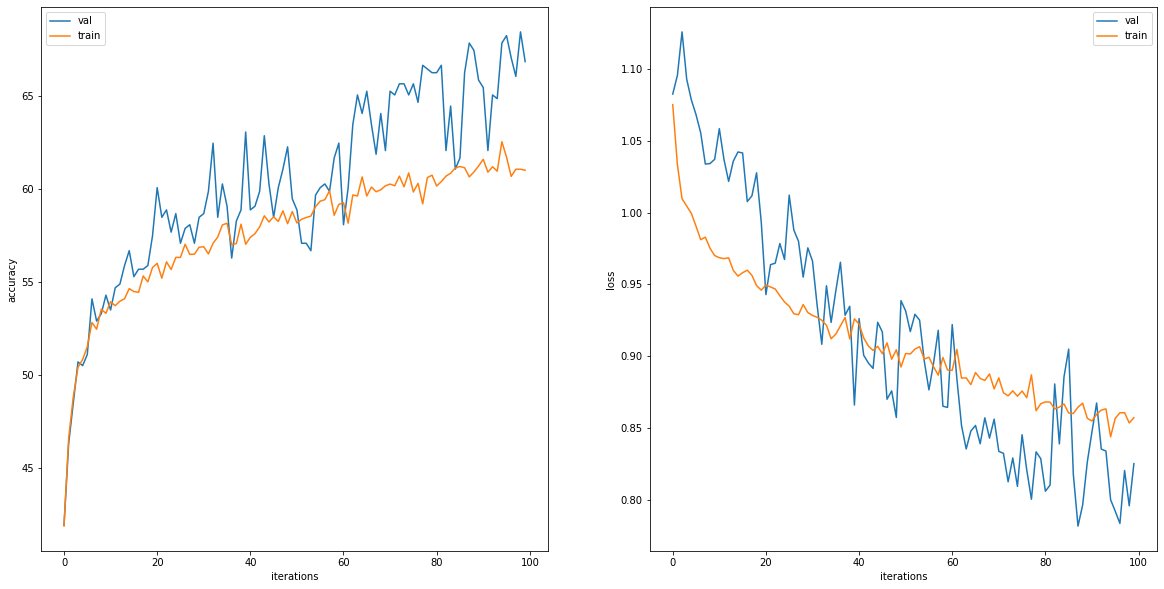

In [18]:
# figure, axis = plt.subplots(2, 2)
# # axis[0,0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.title("Training and Validation Accuracy")
print(ax1.title)
ax1.plot(acc_valid,label="val")
ax1.plot(acc_train,label="train")
ax1.set_xlabel("iterations")
ax1.set_ylabel("accuracy")
ax1.legend()

ax2.plot(losses_valid,label="val")
ax2.plot(losses_train,label="train")
ax2.set_xlabel("iterations")
ax2.set_ylabel("loss")
ax2.legend()


In [19]:
test_accuracy, test_loss = eval_ep(dataloader_val, model, loss_fn, device, len(df_val))
print(f"Accuracy: {test_accuracy}, loss: {test_loss}\n")

nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, d in enumerate(dataloader_test):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        for t, p in zip(targets, preds):
                confusion_matrix[t, p] += 1

scores = pd.DataFrame(index=['negative', 'natural', 'positive', 'average'], columns=['precision', 'recall', 'F1-Score'])
for i, label in enumerate(["negative", "natural", "positive"]):
    p = scores.loc[label, 'precision'] = (confusion_matrix[i, i] / confusion_matrix[i].sum()).item()
    r = scores.loc[label, 'recall'] = (confusion_matrix[i, i] / confusion_matrix[:, i].sum()).item()
    scores.loc[label, 'F1-Score'] = (2*p*r) / (p+r)
scores.loc['average'] = scores.mean().values
scores

batch 1 / 2 -- loss: 0.76949
batch 2 / 2 -- loss: 0.82189
Accuracy: 68.46307385229541, loss: 0.7956885397434235



,precision,recall,F1-Score
negative,0.656489,0.722689,0.688
natural,0.511905,0.614286,0.558442
positive,0.762712,0.625,0.687023
average,0.643702,0.653992,0.644488


In [20]:
display(confusion_matrix)
display(scores)

tensor([[86., 12., 33.],
        [20., 43., 21.],
        [13., 15., 90.]])

,precision,recall,F1-Score
negative,0.656489,0.722689,0.688
natural,0.511905,0.614286,0.558442
positive,0.762712,0.625,0.687023
average,0.643702,0.653992,0.644488


Text(0.5, 57.5, 'Predicted label')

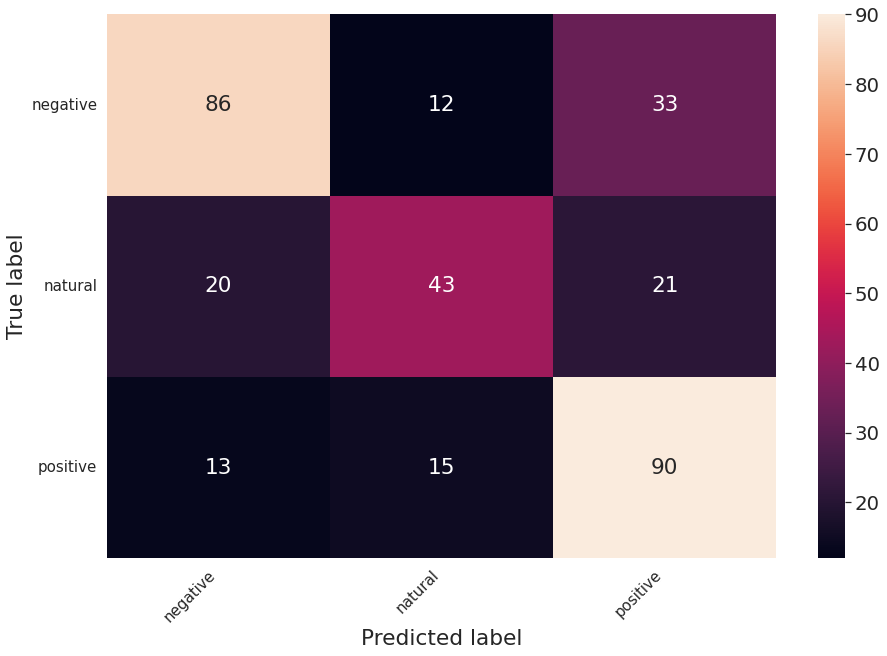

In [21]:
label2class = {0: 'negative', 1: 'natural', 2: 'positive'}

plt.figure(figsize=(15,10))
sns.set(font_scale=1.8)

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [22]:
id = np.random.randint(0,comments.shape[0])
display(id)
idtolabel = ["negative", "natural", "positive"]
sampletxt = comments['comment'][id]
display(sampletxt, idtolabel[comments['sentiment'][id]])
sampletok = tokenizer(
        sampletxt,
        max_length=maxlen,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=False
)
input_ids = sampletok['input_ids'].to(device)
attention_mask = sampletok['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

display(idtolabel[prediction.item()])


7517

'بله عالی برنامتون'

'positive'

'positive'

In [23]:
sampletxt = "تست"
sampletok = tokenizer(
        sampletxt,
        max_length=maxlen,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=False
)
input_ids = sampletok['input_ids'].to(device)
attention_mask = sampletok['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

display(idtolabel[prediction.item()])

'natural'